In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import yfinance as yf

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping

In [2]:
# -----------------------------
# FONCTION MAPE
# -----------------------------
def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    non_zero_actual = actual != 0
    return np.mean(np.abs((actual[non_zero_actual] - forecast[non_zero_actual]) / actual[non_zero_actual])) * 100

In [3]:
# Initialisation du tableau de suivi (à placer en début de notebook si tu veux le remplir dynamiquement)
results = pd.DataFrame(columns=[
    'Pipeline', 'Features', 'Window', 'Batch_size', 'Epochs', 'Période', 'MAPE_1d', 'MAPE_30d', 'Commentaires'
])

def log_test_result(results_df, pipeline, features, window, batch_size, epochs, periode, mape_1d=None, mape_30d=None, commentaires=""):
    """
    Log des résultats de test avec MAPE_1d et/ou MAPE_30d selon le pipeline
    """
    results_df.loc[len(results_df)] = {
        'Pipeline': pipeline,
        'Features': features,
        'Window': window,
        'Batch_size': batch_size,
        'Epochs': epochs,
        'Période': periode,
        'MAPE_1d': mape_1d,
        'MAPE_30d': mape_30d,
        'Commentaires': commentaires
    }
    return results_df

In [13]:
# Définir le ticker pour Bitcoin-USD
ticker_symbol = "BTC-USD"

# Créer un objet Ticker
btc_usd = yf.Ticker(ticker_symbol)

# Récupérer tout l'historique disponible sur 1 an, pour les données journalières.
historical_data = btc_usd.history(period="4y", interval="1d")

In [17]:
# Jeu de features 1 : uniquement 'Close'
df_close = historical_data[['Close']].copy().sort_index(ascending=False)

df_close = df_close.drop(labels=['2025-07-31'], axis=0)

# Jeu de features 2 : 'Close', 'Open', 'High', 'Low', 'Volume'
df_full = historical_data[['Close', 'Open', 'High', 'Low', 'Volume']].copy().sort_index(ascending=False)

df_full = df_full.drop(labels=['2025-07-31'], axis=0)

# Affichage pour vérification
display(df_close.head())
display(df_full.head())

,Close
Date,
2025-07-29 00:00:00+00:00,117922.148438
2025-07-28 00:00:00+00:00,117924.476562
2025-07-27 00:00:00+00:00,119448.492188
2025-07-26 00:00:00+00:00,117947.367188
2025-07-25 00:00:00+00:00,117635.882812


,Close,Open,High,Low,Volume
Date,,,,,
2025-07-29 00:00:00+00:00,117922.148438,117938.585938,119273.867188,116987.367188,68463107433
2025-07-28 00:00:00+00:00,117924.476562,119457.523438,119819.789062,117441.437500,64822943193
2025-07-27 00:00:00+00:00,119448.492188,117944.726562,119815.593750,117859.687500,54683390892
2025-07-26 00:00:00+00:00,117947.367188,117644.843750,118335.687500,117181.226562,48508954046
2025-07-25 00:00:00+00:00,117635.882812,118368.000000,118486.976562,114759.820312,104857024569


In [18]:
# -----------------------------
# PIPELINE 1 : Close seul
# -----------------------------

data_close = df_close.copy()
# Création de la cible : prix de clôture du jour suivant
# On décale la colonne 'Close' de -1 pour obtenir la valeur du lendemain

data_close['Target'] = data_close['Close'].shift(-1)
data_close = data_close.dropna()

# Découpage train/test (80% train, 20% test)
train_size = int(len(data_close) * 0.8)
train_close = data_close.iloc[:train_size]
test_close = data_close.iloc[train_size:]

# Normalisation
scaler_x_close = MinMaxScaler(feature_range=(-1, 1))
scaler_y_close = MinMaxScaler(feature_range=(-1, 1))

X_train_close = scaler_x_close.fit_transform(train_close[['Close']].values)
X_test_close = scaler_x_close.transform(test_close[['Close']].values)
y_train_close = scaler_y_close.fit_transform(train_close[['Target']].values)
y_test_close = scaler_y_close.transform(test_close[['Target']].values)

# Reshape pour LSTM (samples, time_steps, features)
X_train_close = X_train_close.reshape((X_train_close.shape[0], 1, X_train_close.shape[1]))
X_test_close = X_test_close.reshape((X_test_close.shape[0], 1, X_test_close.shape[1]))

print('Shape X_train_close:', X_train_close.shape)
print('Shape y_train_close:', y_train_close.shape)

Shape X_train_close: (1167, 1, 1)
Shape y_train_close: (1167, 1)


In [19]:
# -----------------------------
# PIPELINE 2 : Close, Open, High, Low, Volume
# -----------------------------

data_full = df_full.copy()
# Création de la cible : prix de clôture du jour suivant
data_full['Target'] = data_full['Close'].shift(-1)
data_full = data_full.dropna()

# Découpage train/test (80% train, 20% test)
train_full = data_full.iloc[:train_size]
test_full = data_full.iloc[train_size:]

# Normalisation
scaler_x_full = MinMaxScaler(feature_range=(-1, 1))
scaler_y_full = MinMaxScaler(feature_range=(-1, 1))

X_train_full = scaler_x_full.fit_transform(train_full[['Close', 'Open', 'High', 'Low', 'Volume']].values)
X_test_full = scaler_x_full.transform(test_full[['Close', 'Open', 'High', 'Low', 'Volume']].values)
y_train_full = scaler_y_full.fit_transform(train_full[['Target']].values)
y_test_full = scaler_y_full.transform(test_full[['Target']].values)

# Reshape pour LSTM (samples, time_steps, features)
# Pour window=1: (samples, 1, features) 
X_train_full = X_train_full.reshape((X_train_full.shape[0], 1, X_train_full.shape[1]))
X_test_full = X_test_full.reshape((X_test_full.shape[0], 1, X_test_full.shape[1]))

print('Shape X_train_full:', X_train_full.shape)
print('Shape y_train_full:', y_train_full.shape)

Shape X_train_full: (1167, 1, 5)
Shape y_train_full: (1167, 1)


c:\Users\FOULON\Desktop\BTC-Price-Prediction-LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.3029 - val_loss: 0.2202
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1144 - val_loss: 0.0017
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 8.9660e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 1.8855e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 6.1299e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 1.9919e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 2.1095e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 2.0741e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 1.9025e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAPE (Close seul) : 2.60%


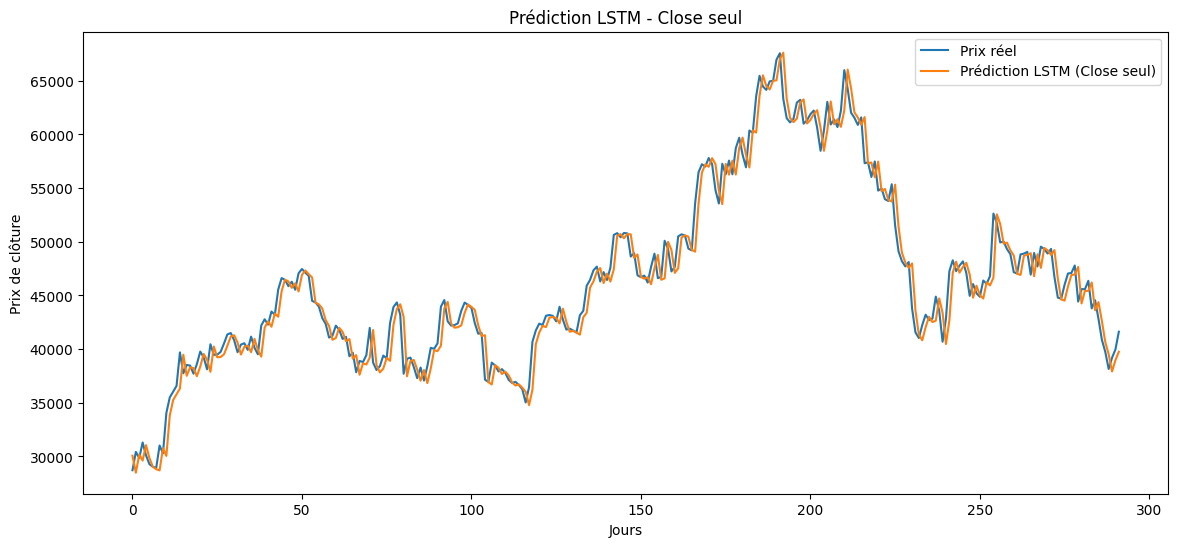

In [20]:
# -----------------------------
# ENTRAÎNEMENT & ÉVALUATION : Close seul
# -----------------------------

model_close = Sequential()
model_close.add(LSTM(100, return_sequences=True, activation='tanh', input_shape=(X_train_close.shape[1], X_train_close.shape[2])))
model_close.add(Dropout(0.1))
model_close.add(LSTM(100, return_sequences=True, activation='tanh'))
model_close.add(Dropout(0.1))
model_close.add(LSTM(100, activation='tanh'))
model_close.add(Dropout(0.1))
model_close.add(Dense(1))

model_close.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_close = model_close.fit(X_train_close, y_train_close, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

# Prédiction et dénormalisation
y_pred_close_scaled = model_close.predict(X_test_close)
y_pred_close = scaler_y_close.inverse_transform(y_pred_close_scaled)
y_test_close_true = scaler_y_close.inverse_transform(y_test_close)

# Calcul du MAPE
mape_close = calculate_mape(y_test_close_true, y_pred_close)
print(f"MAPE (Close seul) : {mape_close:.2f}%")

# Courbe de prédiction
plt.figure(figsize=(14,6))
plt.plot(y_test_close_true, label='Prix réel')
plt.plot(y_pred_close, label='Prédiction LSTM (Close seul)')
plt.title('Prédiction LSTM - Close seul')
plt.xlabel('Jours')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# SAUVEGARDE MANUELLE DES MODÈLES
# -----------------------------

# Modèle 1: Close seul
model_close.save('model_btc_close_only_4y.h5')
print('Modèle Close seul sauvegardé: model_btc_close_only_4y.h5')

In [21]:
# Exemple d'ajout d'un test (à faire après chaque entraînement/évaluation)
results = log_test_result(
    results,
    pipeline='LSTM',
    features='Close',
    window=1,
    batch_size=32,
    epochs=100,
    periode='4y',
    mape_1d=2.60,
    commentaires='Test baseline - Close seul'
)

Epoch 1/100


c:\Users\FOULON\Desktop\BTC-Price-Prediction-LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.2865 - val_loss: 8.8185e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - val_loss: 5.4569e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 3.7708e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 8.0567e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0012
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
MAPE (Close+Open+High+Low+Volume) : 1.60%


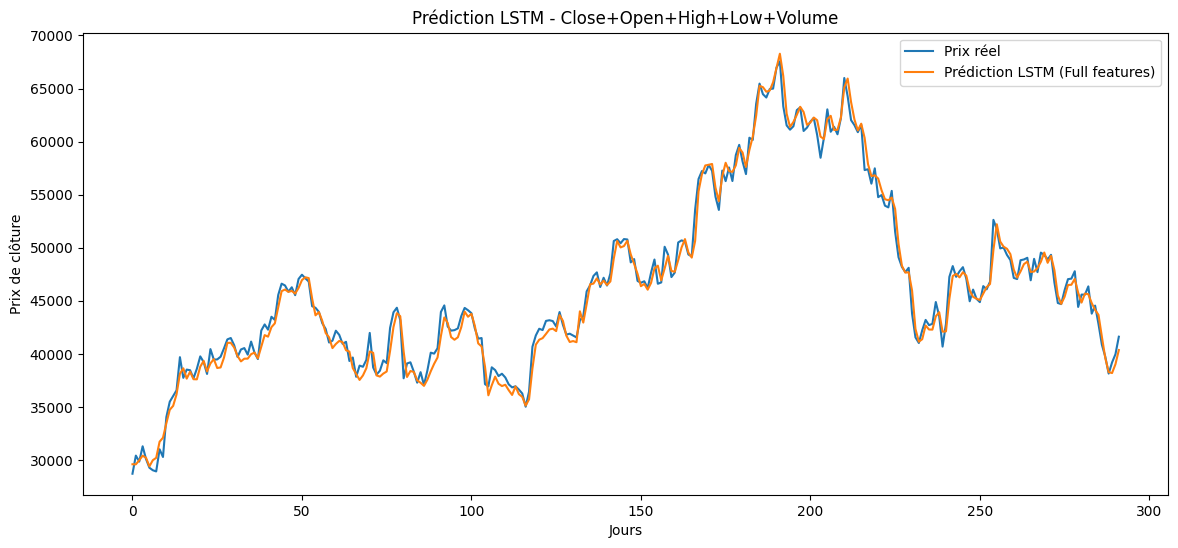

In [62]:
# -----------------------------
# ENTRAÎNEMENT & ÉVALUATION : Close, Open, High, Low, Volume
# -----------------------------
model_full = Sequential()
model_full.add(LSTM(100, return_sequences=True, activation='tanh', input_shape=(X_train_full.shape[1], X_train_full.shape[2])))
model_full.add(Dropout(0.1))
model_full.add(LSTM(100, return_sequences=True, activation='tanh'))
model_full.add(Dropout(0.1))
model_full.add(LSTM(100, activation='tanh'))
model_full.add(Dropout(0.1))
model_full.add(Dense(1))

model_full.compile(optimizer='adam', loss='mean_squared_error')
early_stopping_full = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_full = model_full.fit(X_train_full, y_train_full, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping_full], verbose=1)

# Prédiction et dénormalisation
y_pred_full_scaled = model_full.predict(X_test_full)
y_pred_full = scaler_y_full.inverse_transform(y_pred_full_scaled)
y_test_full_true = scaler_y_full.inverse_transform(y_test_full)

# Calcul du MAPE
mape_full = calculate_mape(y_test_full_true, y_pred_full)
print(f"MAPE (Close+Open+High+Low+Volume) : {mape_full:.2f}%")

# Courbe de prédiction
plt.figure(figsize=(14,6))
plt.plot(y_test_full_true, label='Prix réel')
plt.plot(y_pred_full, label='Prédiction LSTM (Full features)')
plt.title('Prédiction LSTM - Close+Open+High+Low+Volume')
plt.xlabel('Jours')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

In [68]:
# -----------------------------
# SAUVEGARDE MANUELLE DES MODÈLES
# -----------------------------

# Modèle 2: OHLCV 
model_full.save('model_btc_ohlcv_4y.h5')
print('Modèle OHLCV sauvegardé: model_btc_ohlcv_4y.h5')

Modèle OHLCV sauvegardé: model_btc_ohlcv_4y.h5


In [63]:
# Exemple d'ajout d'un test (à faire après chaque entraînement/évaluation)
results = log_test_result(
    results,
    pipeline='LSTM',
    features='Close, Open, High, Low, Volume',
    window=1,
    batch_size=32,
    epochs=100,
    periode='4y',
    mape_1d=1.60,
    commentaires='Test baseline - OHLCV'
)

C:\Users\FOULON\AppData\Local\Temp\ipykernel_27432\3321848529.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df.loc[len(results_df)] = {


In [ ]:
# Affichage
print('Tableau de suivi des tests :')
display(results)

Tableau de suivi des tests :


,Pipeline,Features,Window,Batch_size,Epochs,Période,MAPE_1d,MAPE_30d,Commentaires
0,LSTM,Close,1,32,100,4y,2.6,NaN,Test baseline - Close seul
1,LSTM,"Close, Open, High, Low, Volume",1,32,100,4y,1.6,NaN,Test baseline - OHLCV
2,LSTM Rolling,7 features (OHLCV + indicateurs),1,32,100,1y,NaN,15.519804,Prédiction rolling 30 jours


In [ ]:
# Sauvegarder du tableau de résultats
results.to_csv('resultats_tests_lstm.csv', index=False)

In [ ]:
# Charge le dataset "Date	Close	Open	High	Low	Volume"
# 📊 Sauvegarde de data_full avec Date en format datetime
data_export = data_full.reset_index()
# ✅ CORRECTION: normalize() ne prend pas de paramètre format
data_export['Date'] = pd.to_datetime(data_export['Date']).dt.strftime('%Y-%m-%d')
data_export.to_csv('Btc_full.csv', index=False)

print("✅ Fichier market_data.csv sauvegardé avec Date en format datetime")

✅ Fichier market_data.csv sauvegardé avec Date en format datetime


In [ ]:
df = pd.read_csv('Btc_full.csv')
df

,Date,Close,Open,High,Low,Volume
0,2025-07-29,117922.148438,117938.585938,119273.867188,116987.367188,68463107433
1,2025-07-28,117924.476562,119457.523438,119819.789062,117441.437500,64822943193
2,2025-07-27,119448.492188,117944.726562,119815.593750,117859.687500,54683390892
3,2025-07-26,117947.367188,117644.843750,118335.687500,117181.226562,48508954046
4,2025-07-25,117635.882812,118368.000000,118486.976562,114759.820312,104857024569
...,...,...,...,...,...,...
1454,2021-08-05,40869.554688,39744.515625,41341.933594,37458.003906,35185031017
1455,2021-08-04,39747.503906,38213.332031,39952.296875,37589.164062,25372562724
1456,2021-08-03,38152.980469,39178.402344,39750.031250,37782.050781,26189830450
1457,2021-08-02,39201.945312,39907.261719,40419.179688,38746.347656,25595265436


In [ ]:
df_csv = pd.read_csv('market_data_2025-07-31.csv')
df_csv

,Date,price_usd,MM_200,RSI_14
0,2025-07-31,118119.28,58.3009,99050.7480
1,2025-07-30,117830.15,57.3607,98932.6997
2,2025-07-29,117933.39,57.7928,98816.3740
3,2025-07-28,118070.59,58.3350,98700.2130
4,2025-07-27,119465.52,64.0043,98572.5972
...,...,...,...,...
152,2025-03-01,86018.76,82123.4971,31.4563
153,2025-02-28,84297.73,81996.4192,25.6216
154,2025-02-27,84625.19,81871.7245,26.0128
155,2025-02-26,84111.78,81742.2110,24.3307


In [52]:
df_merge = pd.merge(df, df_csv, on='Date', how='left')

df_merge.drop(columns=['price_usd'], inplace=True)

df_merge.dropna(inplace=True)

df_merge.to_csv('market_data.csv', index=False)

In [56]:
# -----------------------------
# PIPELINE 3 : Rolling 30 jours (7 features, 1 an)
# -----------------------------

# Récupération des données avec Date comme index
historical_data_1y = pd.read_csv('market_data.csv', index_col='Date', parse_dates=['Date'])

# Sélection des 7 features (ajustez selon vos besoins réels)
# Exemple avec Close, Open, High, Low, Volume + 2 indicateurs techniques
df_rolling = historical_data_1y[['Close', 'Open', 'High', 'Low', 'Volume', 'MM_200', 'RSI_14']].copy().sort_index(ascending=False)

# On garde seulement les 7 features et on supprime les NaN
df_rolling = df_rolling.dropna()

print(f"Dataset rolling 30j: {df_rolling.shape[0]} lignes, {df_rolling.shape[1]} features")
print("Features:", list(df_rolling.columns))
print(f"Période: du {df_rolling.index.min().strftime('%Y-%m-%d')} au {df_rolling.index.max().strftime('%Y-%m-%d')}")
print(f"Index type: {type(df_rolling.index)} - {df_rolling.index.dtype}")
display(df_rolling)

Dataset rolling 30j: 155 lignes, 7 features
Features: ['Close', 'Open', 'High', 'Low', 'Volume', 'MM_200', 'RSI_14']
Période: du 2025-02-25 au 2025-07-29
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> - datetime64[ns]


,Close,Open,High,Low,Volume,MM_200,RSI_14
Date,,,,,,,
2025-07-29,117922.148438,117938.585938,119273.867188,116987.367188,68463107433,98816.3740,57.7928
2025-07-28,117924.476562,119457.523438,119819.789062,117441.437500,64822943193,98700.2130,58.3350
2025-07-27,119448.492188,117944.726562,119815.593750,117859.687500,54683390892,98572.5972,64.0043
2025-07-26,117947.367188,117644.843750,118335.687500,117181.226562,48508954046,98450.4528,60.1476
2025-07-25,117635.882812,118368.000000,118486.976562,114759.820312,104857024569,98345.3145,60.5908
...,...,...,...,...,...,...,...
2025-03-01,86031.914062,84373.867188,86522.304688,83794.234375,29190628396,82123.4971,31.4563
2025-02-28,84373.007812,84705.625000,85036.320312,78248.914062,83610570576,81996.4192,25.6216
2025-02-27,84704.226562,84076.859375,87000.781250,83144.960938,52659591954,81871.7245,26.0128


In [57]:
# Préparation des données pour le modèle rolling
data_rolling = df_rolling.copy()

# Pour le rolling, on ne crée PAS de target shift, le modèle va prédire jour par jour
# Découpage train/test (80% train, 20% test)
train_size_rolling = int(len(data_rolling) * 0.8)
train_rolling = data_rolling.iloc[:train_size_rolling]
test_rolling = data_rolling.iloc[train_size_rolling:]

print(f"Train rolling: {len(train_rolling)} jours")
print(f"Test rolling: {len(test_rolling)} jours")

# Normalisation
scaler_x_rolling = MinMaxScaler(feature_range=(-1, 1))
scaler_y_rolling = MinMaxScaler(feature_range=(-1, 1))

X_train_rolling = scaler_x_rolling.fit_transform(train_rolling.values)
X_test_rolling = scaler_x_rolling.transform(test_rolling.values)

# Pour l'entraînement, on crée la target comme le close du jour suivant
y_train_rolling = scaler_y_rolling.fit_transform(train_rolling['Close'].shift(-1).dropna().values.reshape(-1, 1))
X_train_rolling = X_train_rolling[:-1]  # On enlève la dernière ligne car pas de target

# Reshape pour LSTM (samples, time_steps, features)
X_train_rolling = X_train_rolling.reshape((X_train_rolling.shape[0], 1, X_train_rolling.shape[1]))

print('Shape X_train_rolling:', X_train_rolling.shape)
print('Shape y_train_rolling:', y_train_rolling.shape)


Train rolling: 124 jours
Test rolling: 31 jours
Shape X_train_rolling: (123, 1, 7)
Shape y_train_rolling: (123, 1)


In [69]:
# -----------------------------
# ENTRAÎNEMENT MODÈLE ROLLING 30 JOURS
# -----------------------------

model_rolling = Sequential()
model_rolling.add(LSTM(100, return_sequences=True, activation='tanh', input_shape=(X_train_rolling.shape[1], X_train_rolling.shape[2])))
model_rolling.add(Dropout(0.1))
model_rolling.add(LSTM(100, return_sequences=True, activation='tanh'))
model_rolling.add(Dropout(0.1))
model_rolling.add(LSTM(100, activation='tanh'))
model_rolling.add(Dropout(0.1))
model_rolling.add(Dense(1))

model_rolling.compile(optimizer='adam', loss='mean_squared_error')
early_stopping_rolling = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Entraînement du modèle rolling...")
history_rolling = model_rolling.fit(X_train_rolling, y_train_rolling, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping_rolling], verbose=1)

c:\Users\FOULON\Desktop\BTC-Price-Prediction-LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entraînement du modèle rolling...
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.2433 - val_loss: 0.4986
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2486 - val_loss: 0.5096
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1990 - val_loss: 0.5150
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1904 - val_loss: 0.5103
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1504 - val_loss: 0.4945
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0981 - val_loss: 0.4611
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0532 - val_loss: 0.4115
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0267 - val_loss: 0.3587
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0368 - val_loss: 0.3333
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0302 - val_loss: 0.3333
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0202 - val_loss: 0.3291
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

In [70]:
# -----------------------------
# PRÉDICTION ROLLING 30 JOURS (Option B)
# -----------------------------

def predict_rolling_30_days(model, initial_data, scaler_x, scaler_y, n_days=30):
    """
    Prédiction rolling: utilise les prédictions précédentes pour prédire les jours suivants
    """
    predictions = []
    current_data = initial_data.copy()  # Données normalisées
    
    for day in range(n_days):
        # Reshape pour le modèle LSTM
        input_data = current_data.reshape((1, 1, current_data.shape[0]))
        
        # Prédiction du prix de clôture du jour suivant
        pred_scaled = model.predict(input_data, verbose=0)
        pred_price = scaler_y.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred_price)
        
        # Mise à jour des données pour la prochaine prédiction
        # On utilise la prédiction comme nouveau Close et on ajuste les autres features
        current_data_unscaled = scaler_x.inverse_transform(current_data.reshape(1, -1))[0]
        
        # Mise à jour: Close = prédiction, on garde les autres features ou les ajuste
        current_data_unscaled[0] = pred_price  # Close
        # Pour simplifier, on peut garder les autres features ou les faire évoluer selon une logique
        # Ici on garde les autres features constantes (simplification)
        
        # Re-normalisation
        current_data = scaler_x.transform(current_data_unscaled.reshape(1, -1))[0]
    
    return np.array(predictions)

# Point de départ: dernière observation du set d'entraînement
last_train_data = X_train_rolling[-1, 0, :]  # Dernière ligne d'entraînement

print("Prédiction rolling 30 jours...")
rolling_predictions = predict_rolling_30_days(
    model_rolling, 
    last_train_data, 
    scaler_x_rolling, 
    scaler_y_rolling, 
    n_days=30
)

print(f"Prédictions rolling générées: {len(rolling_predictions)} jours")
print(f"Prix initial: {scaler_y_rolling.inverse_transform(train_rolling['Close'].iloc[-1:].values.reshape(-1, 1))[0, 0]:.2f}$")
print(f"Prix prédit J+30: {rolling_predictions[-1]:.2f}$")


Prédiction rolling 30 jours...
Prédictions rolling générées: 30 jours
Prix initial: 1844203929.01$
Prix prédit J+30: 86850.57$


MAPE Rolling 30 jours: 3.14%


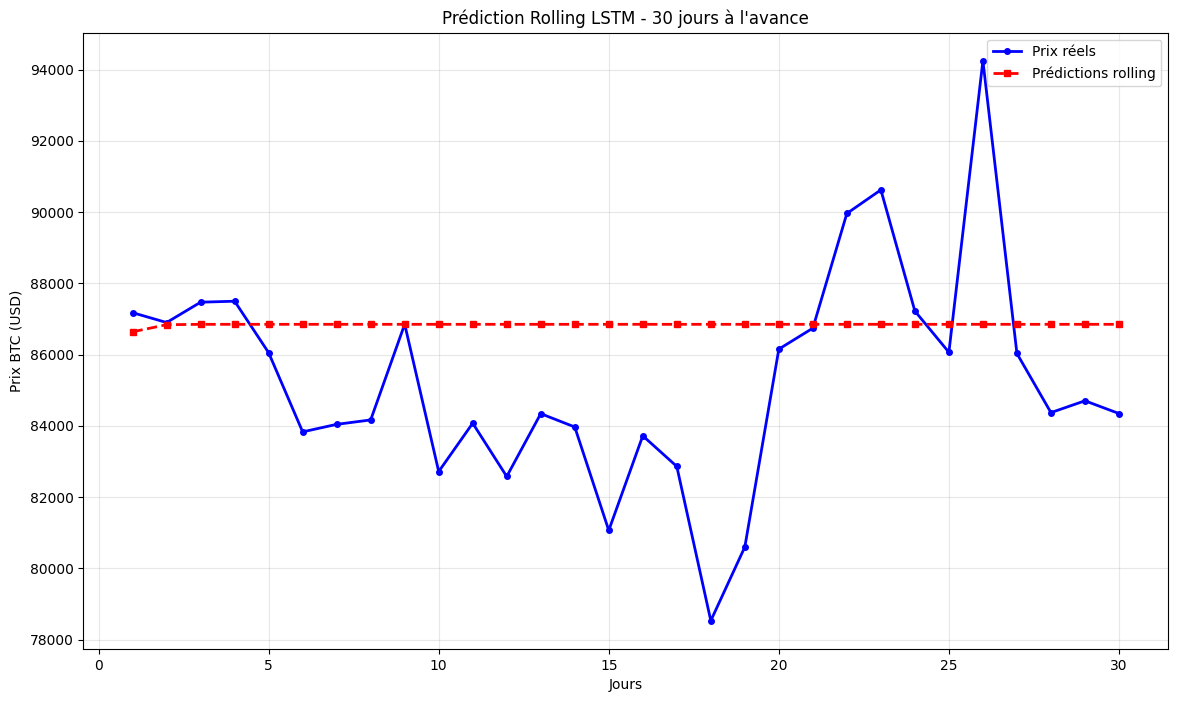

C:\Users\FOULON\AppData\Local\Temp\ipykernel_27432\3321848529.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df.loc[len(results_df)] = {


In [71]:
# -----------------------------
# ÉVALUATION ROLLING 30 JOURS
# -----------------------------

# Pour évaluer, on compare avec les vraies valeurs du test set (si disponibles)
if len(test_rolling) >= 30:
    # Vraies valeurs des 30 premiers jours du test set
    true_prices_30d = test_rolling['Close'].iloc[:30].values
    
    # Calcul du MAPE sur 30 jours
    mape_30d = calculate_mape(true_prices_30d, rolling_predictions)
    print(f"MAPE Rolling 30 jours: {mape_30d:.2f}%")
    
    # Visualisation
    plt.figure(figsize=(14, 8))
    days = range(1, 31)
    plt.plot(days, true_prices_30d, 'b-', label='Prix réels', linewidth=2, marker='o', markersize=4)
    plt.plot(days, rolling_predictions, 'r--', label='Prédictions rolling', linewidth=2, marker='s', markersize=4)
    plt.title('Prédiction Rolling LSTM - 30 jours à l\'avance')
    plt.xlabel('Jours')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Log du résultat
    results = log_test_result(
        results,
        pipeline='LSTM Rolling',
        features=f'{df_rolling.shape[1]} features (OHLCV + indicateurs)',
        window=1,
        batch_size=32,
        epochs=100,
        periode='1y',
        mape_30d=mape_30d,
        commentaires='Prédiction rolling 30 jours'
    )
    
else:
    print(f"Test set trop petit ({len(test_rolling)} jours) pour évaluer 30 jours")
    
    # Visualisation des prédictions seules
    plt.figure(figsize=(14, 8))
    plt.plot(range(1, 31), rolling_predictions, 'r--', label='Prédictions rolling 30j', linewidth=2, marker='s')
    plt.title('Prédictions Rolling LSTM - 30 jours à l\'avance')
    plt.xlabel('Jours')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Log sans MAPE
    results = log_test_result(
        results,
        pipeline='LSTM Rolling',
        features=f'{df_rolling.shape[1]} features (OHLCV + indicateurs)',
        window=1,
        batch_size=32,
        epochs=100,
        periode='1y',
        commentaires='Prédiction rolling 30 jours - pas assez de données test'
    )

In [72]:
# -----------------------------
# SAUVEGARDE MANUELLE DES MODÈLES
# -----------------------------

# Modèle 3: Rolling 30 jours
model_rolling.save('model_btc_rolling_30d_1y.h5')
print('Modèle Rolling 30j sauvegardé: model_btc_rolling_30d_1y.h5')

Modèle Rolling 30j sauvegardé: model_btc_rolling_30d_1y.h5


=== TABLEAU DE SUIVI DES TESTS LSTM ===


,Pipeline,Features,Window,Batch_size,Epochs,Période,MAPE_1d,MAPE_30d,Commentaires
0,LSTM,Close,1,32,100,4y,2.6,NaN,Test baseline - Close seul
1,LSTM,"Close, Open, High, Low, Volume",1,32,100,4y,1.6,NaN,Test baseline - OHLCV
2,LSTM Rolling,7 features (OHLCV + indicateurs),1,32,100,1y,NaN,3.141007,Prédiction rolling 30 jours



Tableau sauvegardé: resultats_tests_lstm_complets.csv


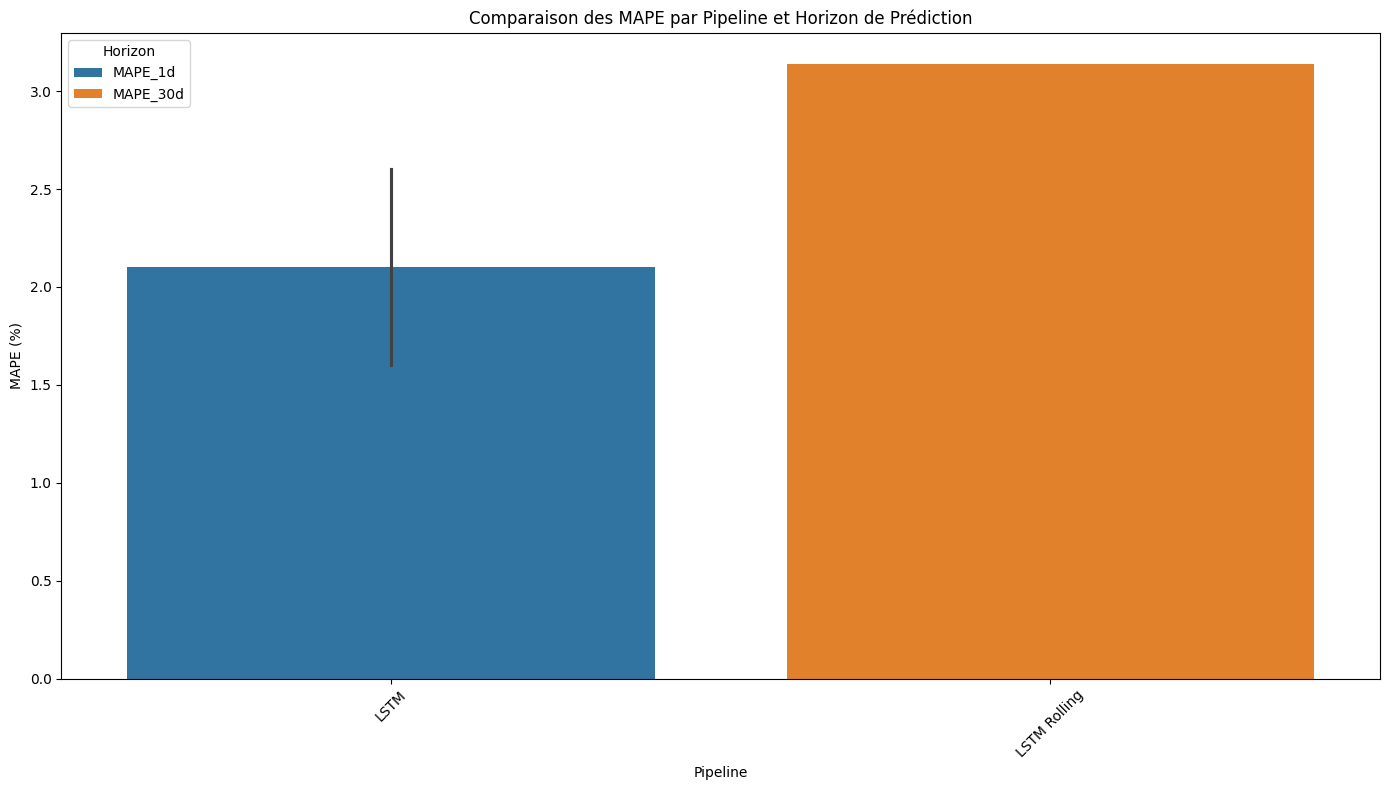


=== RÉSUMÉ DES PIPELINES ===
✅ Pipeline 1: Close seul, 4 ans, window=1 → Prédiction 1 jour
✅ Pipeline 2: OHLCV, 4 ans, window=1 → Prédiction 1 jour
✅ Pipeline 3: 7 features, 1 an, rolling → Prédiction 30 jours


In [75]:
# -----------------------------
# RÉSUMÉ ET VISUALISATION FINALE
# -----------------------------

# Affichage du tableau final
print('=== TABLEAU DE SUIVI DES TESTS LSTM ===')
display(results)

# Sauvegarde du tableau
results.to_csv('resultats_tests_lstm_complets.csv', index=False)
print('\nTableau sauvegardé: resultats_tests_lstm_complets.csv')

# Visualisation comparative des MAPE
if len(results) > 0:
    results_plot = results.melt(
        id_vars=['Pipeline', 'Features', 'Window', 'Batch_size', 'Epochs', 'Commentaires'], 
        value_vars=['MAPE_1d', 'MAPE_30d'],
        var_name='Horizon', value_name='MAPE'
    )
    
    # Filtrer les valeurs non nulles
    results_plot = results_plot.dropna(subset=['MAPE'])
    
    if len(results_plot) > 0:
        plt.figure(figsize=(14, 8))
        sns.barplot(data=results_plot, x='Pipeline', y='MAPE', hue='Horizon')
        plt.ylabel('MAPE (%)')
        plt.title('Comparaison des MAPE par Pipeline et Horizon de Prédiction')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
print("\n=== RÉSUMÉ DES PIPELINES ===")
print("✅ Pipeline 1: Close seul, 4 ans, window=1 → Prédiction 1 jour")
print("✅ Pipeline 2: OHLCV, 4 ans, window=1 → Prédiction 1 jour") 
print("✅ Pipeline 3: 7 features, 1 an, rolling → Prédiction 30 jours")